In [2]:
# import os

# max_files = 50  # number of files to print
# count = 0

# for dirname, _, filenames in os.walk('./kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#         count += 1
#         if count >= max_files:
#             break
#     if count >= max_files:
#         break

import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('./processed_images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

./processed_images\data.zip
./processed_images\samples.zip
./processed_images\data\Data_Entry_2017.csv
./processed_images\data\images_001\images_001.zip
./processed_images\data\images_001\images\00000001_000.png
./processed_images\data\images_001\images\00000001_001.png
./processed_images\data\images_001\images\00000001_002.png
./processed_images\data\images_001\images\00000002_000.png
./processed_images\data\images_001\images\00000003_000.png
./processed_images\data\images_001\images\00000003_001.png
./processed_images\data\images_001\images\00000003_002.png
./processed_images\data\images_001\images\00000003_003.png
./processed_images\data\images_001\images\00000003_004.png
./processed_images\data\images_001\images\00000003_005.png
./processed_images\data\images_001\images\00000003_006.png
./processed_images\data\images_001\images\00000003_007.png
./processed_images\data\images_001\images\00000004_000.png
./processed_images\data\images_001\images\00000005_000.png
./processed_images\da

In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.models import densenet121, DenseNet121_Weights
import time
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Yasiru Laksara\miniconda3\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# ---------------- CONFIG ---------------- #
CONFIG = {
    "model": "replication_of_dannynet",
    "batch_size": 8,
    "learning_rate": 0.00005,
    "epochs": 25,
    "num_workers": 0,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "./processed_images/data",  # <- CHANGE to your Kaggle dataset path
    "patience": 5,
    "seed": 42,
    "image_size": 224,
}

In [6]:
print(CONFIG["device"])

cuda


In [7]:
# ---------------- TRANSFORMS ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [8]:
# ---------------- ATTENTION MODULE ---------------- #
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

In [9]:
# ---------------- MODEL WITH ATTENTION ---------------- #
class DenseNetCBAM(nn.Module):
    def __init__(self, num_classes=14):
        super(DenseNetCBAM, self).__init__()
        # Load pretrained DenseNet121
        self.densenet = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        
        # Get the number of features from the last layer
        num_features = self.densenet.classifier.in_features
        
        # Remove the classifier layer
        self.densenet.classifier = nn.Identity()
        
        # Add CBAM attention after feature extraction
        self.attention = CBAM(num_features)
        
        # Add global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Add dropout and final classifier
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        # Extract features using DenseNet backbone
        features = self.densenet.features(x)
        
        # Apply attention mechanism
        attended_features = self.attention(features)
        
        # Global average pooling
        pooled = self.global_pool(attended_features)
        pooled = pooled.view(pooled.size(0), -1)
        
        # Apply dropout and classifier
        output = self.dropout(pooled)
        output = self.classifier(output)
        
        return output

# Create model with attention
model_cbam = DenseNetCBAM(num_classes=14).to(CONFIG["device"])

# Original model for comparison
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 14)
model = model.to(CONFIG["device"])

In [10]:
# ---------------- LOSS ---------------- #
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [11]:
# ---------------- OPTIMIZERS AND SCHEDULERS ---------------- #
# For CBAM model
criterion_cbam = FocalLoss(alpha=1, gamma=2)
optimizer_cbam = torch.optim.AdamW(model_cbam.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler_cbam = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_cbam, 'min', patience=1, factor=0.1)

# For original model (for comparison)
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

# Print model comparison
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Original DenseNet parameters: {count_parameters(model):,}")
print(f"DenseNet + CBAM parameters: {count_parameters(model_cbam):,}")
cbam_overhead = count_parameters(model_cbam) - count_parameters(model)
print(f"CBAM attention overhead: {cbam_overhead:,} parameters ({cbam_overhead/count_parameters(model)*100:.2f}% increase)")

Original DenseNet parameters: 6,968,206
DenseNet + CBAM parameters: 7,099,376
CBAM attention overhead: 131,170 parameters (1.88% increase)


In [12]:
# ---------------- DATA ---------------- #
data_path = CONFIG["data_dir"]
# csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
csv_file = "kaggle\input\data\Data_Entry_2017.csv"  # <- CHANGE to your Kaggle dataset path
df = pd.read_csv(csv_file)

In [13]:
# ---------------- MODEL SELECTION ---------------- #
# Choose which model to use for training
USE_ATTENTION = True  # Set to False to use original DenseNet, True to use DenseNet + CBAM

if USE_ATTENTION:
    print("🔍 Using DenseNet with CBAM attention mechanism")
    model = model_cbam
    criterion = criterion_cbam
    optimizer = optimizer_cbam
    scheduler = scheduler_cbam
    CONFIG["model"] = "densenet121_cbam"
else:
    print("📦 Using original DenseNet121")
    CONFIG["model"] = "densenet121_original"

print(f"✅ Selected model: {CONFIG['model']}")
print(f"📊 Total trainable parameters: {count_parameters(model):,}")

🔍 Using DenseNet with CBAM attention mechanism
✅ Selected model: densenet121_cbam
📊 Total trainable parameters: 7,099,376


In [14]:
image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder


In [15]:
df = df[df['Image Index'].isin(image_to_folder.keys())]

In [16]:
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=CONFIG["seed"])
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

In [17]:
train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

In [18]:
disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [19]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [20]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [21]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [22]:
# ---------------- METRICS ---------------- #
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [23]:
def evaluate(model, loader, criterion, device, desc="[Test]"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    thresholds = get_optimal_thresholds(all_labels, all_preds)

    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        preds_binary[:, i] = (all_preds[:, i] > thresholds[i]).astype(int)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(14)]
    f1_scores = [f1_score(all_labels[:, i], preds_binary[:, i]) for i in range(14)]

    avg_auc = np.mean(auc_scores)
    avg_f1 = np.mean(f1_scores)

    for i, disease in enumerate(disease_list):
        print(f"{desc} {disease} AUC: {auc_scores[i]:.4f} | F1: {f1_scores[i]:.4f}")

    print(f"{desc} Avg AUC: {avg_auc:.4f}, Avg F1: {avg_f1:.4f}")

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": dict(zip(disease_list, auc_scores)),
        "f1_dict": dict(zip(disease_list, f1_scores)),
        "thresholds": dict(zip(disease_list, thresholds))
    }


In [24]:
# ---------------- TRAINING ---------------- #
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss


In [25]:
def validate(model, valloader, criterion, device):
    return evaluate(model, valloader, criterion, device, desc="[Validate]")


In [26]:
# ---------------- MAIN LOOP ---------------- #
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []
epochs_list = []

print("Starting training...")
print("-" * 80)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Training
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    
    # Validation
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_stats["loss"])
    epochs_list.append(epoch + 1)
    
    # Display epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_stats['loss']:.4f}")
    print(f"Validation AUC: {val_stats['avg_auc']:.4f}")
    print(f"Validation F1: {val_stats['avg_f1']:.4f}")
    
    scheduler.step(val_stats["loss"])

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✓ NEW BEST MODEL! Saved at {checkpoint_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

print("\nTraining completed!")
print("-" * 80)

Starting training...
--------------------------------------------------------------------------------

Epoch 1/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:40<00:00,  4.66it/s]


[Validate] Atelectasis AUC: 0.7889 | F1: 0.3648
[Validate] Cardiomegaly AUC: 0.8556 | F1: 0.3356
[Validate] Consolidation AUC: 0.7894 | F1: 0.2292
[Validate] Edema AUC: 0.8467 | F1: 0.1683
[Validate] Effusion AUC: 0.8451 | F1: 0.4857
[Validate] Emphysema AUC: 0.8657 | F1: 0.4333
[Validate] Fibrosis AUC: 0.7741 | F1: 0.1119
[Validate] Hernia AUC: 0.8022 | F1: 0.0000
[Validate] Infiltration AUC: 0.6933 | F1: 0.4080
[Validate] Mass AUC: 0.8155 | F1: 0.3558
[Validate] Nodule AUC: 0.7184 | F1: 0.2345
[Validate] Pleural_Thickening AUC: 0.7733 | F1: 0.1962
[Validate] Pneumonia AUC: 0.6990 | F1: 0.0694
[Validate] Pneumothorax AUC: 0.8774 | F1: 0.4176
[Validate] Avg AUC: 0.7960, Avg F1: 0.2722
Training Loss: 0.0472
Validation Loss: 0.0429
Validation AUC: 0.7960
Validation F1: 0.2722
✓ NEW BEST MODEL! Saved at models\best_model_20250917-182602.pth

Epoch 2/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:40<00:00,  4.65it/s]


[Validate] Atelectasis AUC: 0.8191 | F1: 0.3941
[Validate] Cardiomegaly AUC: 0.8796 | F1: 0.3529
[Validate] Consolidation AUC: 0.8046 | F1: 0.2628
[Validate] Edema AUC: 0.8641 | F1: 0.1699
[Validate] Effusion AUC: 0.8557 | F1: 0.4932
[Validate] Emphysema AUC: 0.8848 | F1: 0.4315
[Validate] Fibrosis AUC: 0.8200 | F1: 0.1382
[Validate] Hernia AUC: 0.8373 | F1: 0.0690
[Validate] Infiltration AUC: 0.6991 | F1: 0.4205
[Validate] Mass AUC: 0.8275 | F1: 0.4104
[Validate] Nodule AUC: 0.7443 | F1: 0.3025
[Validate] Pleural_Thickening AUC: 0.7817 | F1: 0.2342
[Validate] Pneumonia AUC: 0.7136 | F1: 0.0756
[Validate] Pneumothorax AUC: 0.8785 | F1: 0.4116
[Validate] Avg AUC: 0.8150, Avg F1: 0.2976
Training Loss: 0.0443
Validation Loss: 0.0413
Validation AUC: 0.8150
Validation F1: 0.2976
✓ NEW BEST MODEL! Saved at models\best_model_20250917-191933.pth

Epoch 3/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [03:24<00:00,  3.64it/s]


[Validate] Atelectasis AUC: 0.8206 | F1: 0.3980
[Validate] Cardiomegaly AUC: 0.8812 | F1: 0.3636
[Validate] Consolidation AUC: 0.8058 | F1: 0.2508
[Validate] Edema AUC: 0.8685 | F1: 0.1818
[Validate] Effusion AUC: 0.8555 | F1: 0.5004
[Validate] Emphysema AUC: 0.9065 | F1: 0.5312
[Validate] Fibrosis AUC: 0.8165 | F1: 0.1403
[Validate] Hernia AUC: 0.8780 | F1: 0.2745
[Validate] Infiltration AUC: 0.7054 | F1: 0.4307
[Validate] Mass AUC: 0.8456 | F1: 0.3952
[Validate] Nodule AUC: 0.7471 | F1: 0.3172
[Validate] Pleural_Thickening AUC: 0.8111 | F1: 0.2524
[Validate] Pneumonia AUC: 0.7276 | F1: 0.0762
[Validate] Pneumothorax AUC: 0.8860 | F1: 0.4481
[Validate] Avg AUC: 0.8254, Avg F1: 0.3258
Training Loss: 0.0435
Validation Loss: 0.0405
Validation AUC: 0.8254
Validation F1: 0.3258
✓ NEW BEST MODEL! Saved at models\best_model_20250917-202504.pth

Epoch 4/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:43<00:00,  4.58it/s]


[Validate] Atelectasis AUC: 0.8279 | F1: 0.4158
[Validate] Cardiomegaly AUC: 0.8803 | F1: 0.3641
[Validate] Consolidation AUC: 0.8032 | F1: 0.2505
[Validate] Edema AUC: 0.8649 | F1: 0.1973
[Validate] Effusion AUC: 0.8608 | F1: 0.5172
[Validate] Emphysema AUC: 0.8906 | F1: 0.4863
[Validate] Fibrosis AUC: 0.8003 | F1: 0.1382
[Validate] Hernia AUC: 0.9293 | F1: 0.3902
[Validate] Infiltration AUC: 0.7034 | F1: 0.4191
[Validate] Mass AUC: 0.8534 | F1: 0.4086
[Validate] Nodule AUC: 0.7606 | F1: 0.3358
[Validate] Pleural_Thickening AUC: 0.8097 | F1: 0.2382
[Validate] Pneumonia AUC: 0.7282 | F1: 0.0765
[Validate] Pneumothorax AUC: 0.8845 | F1: 0.4381
[Validate] Avg AUC: 0.8284, Avg F1: 0.3340
Training Loss: 0.0429
Validation Loss: 0.0407
Validation AUC: 0.8284
Validation F1: 0.3340
✓ NEW BEST MODEL! Saved at models\best_model_20250917-213102.pth

Epoch 5/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:40<00:00,  4.66it/s]


[Validate] Atelectasis AUC: 0.8352 | F1: 0.4248
[Validate] Cardiomegaly AUC: 0.8625 | F1: 0.3736
[Validate] Consolidation AUC: 0.8066 | F1: 0.2530
[Validate] Edema AUC: 0.8703 | F1: 0.2039
[Validate] Effusion AUC: 0.8653 | F1: 0.5071
[Validate] Emphysema AUC: 0.9138 | F1: 0.5056
[Validate] Fibrosis AUC: 0.8073 | F1: 0.1581
[Validate] Hernia AUC: 0.9224 | F1: 0.3810
[Validate] Infiltration AUC: 0.7110 | F1: 0.4271
[Validate] Mass AUC: 0.8292 | F1: 0.4028
[Validate] Nodule AUC: 0.7621 | F1: 0.3372
[Validate] Pleural_Thickening AUC: 0.8304 | F1: 0.2406
[Validate] Pneumonia AUC: 0.7514 | F1: 0.0915
[Validate] Pneumothorax AUC: 0.8737 | F1: 0.4340
[Validate] Avg AUC: 0.8315, Avg F1: 0.3386
Training Loss: 0.0425
Validation Loss: 0.0403
Validation AUC: 0.8315
Validation F1: 0.3386
✓ NEW BEST MODEL! Saved at models\best_model_20250917-223304.pth

Epoch 6/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:38<00:00,  4.72it/s]


[Validate] Atelectasis AUC: 0.8285 | F1: 0.4214
[Validate] Cardiomegaly AUC: 0.8510 | F1: 0.3774
[Validate] Consolidation AUC: 0.8075 | F1: 0.2559
[Validate] Edema AUC: 0.8723 | F1: 0.2009
[Validate] Effusion AUC: 0.8640 | F1: 0.5054
[Validate] Emphysema AUC: 0.9098 | F1: 0.5019
[Validate] Fibrosis AUC: 0.8307 | F1: 0.1674
[Validate] Hernia AUC: 0.9650 | F1: 0.4651
[Validate] Infiltration AUC: 0.7178 | F1: 0.4324
[Validate] Mass AUC: 0.8398 | F1: 0.3885
[Validate] Nodule AUC: 0.7643 | F1: 0.3411
[Validate] Pleural_Thickening AUC: 0.8175 | F1: 0.2558
[Validate] Pneumonia AUC: 0.7154 | F1: 0.0713
[Validate] Pneumothorax AUC: 0.8875 | F1: 0.4609
[Validate] Avg AUC: 0.8337, Avg F1: 0.3461
Training Loss: 0.0420
Validation Loss: 0.0402
Validation AUC: 0.8337
Validation F1: 0.3461
✓ NEW BEST MODEL! Saved at models\best_model_20250917-233716.pth

Epoch 7/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:27<00:00,  5.08it/s]


[Validate] Atelectasis AUC: 0.8386 | F1: 0.4226
[Validate] Cardiomegaly AUC: 0.8743 | F1: 0.3746
[Validate] Consolidation AUC: 0.8053 | F1: 0.2601
[Validate] Edema AUC: 0.8811 | F1: 0.2011
[Validate] Effusion AUC: 0.8690 | F1: 0.5104
[Validate] Emphysema AUC: 0.9164 | F1: 0.4800
[Validate] Fibrosis AUC: 0.8380 | F1: 0.1707
[Validate] Hernia AUC: 0.9250 | F1: 0.4286
[Validate] Infiltration AUC: 0.7072 | F1: 0.4208
[Validate] Mass AUC: 0.8483 | F1: 0.4015
[Validate] Nodule AUC: 0.7641 | F1: 0.3329
[Validate] Pleural_Thickening AUC: 0.8410 | F1: 0.2497
[Validate] Pneumonia AUC: 0.7397 | F1: 0.0677
[Validate] Pneumothorax AUC: 0.8815 | F1: 0.4230
[Validate] Avg AUC: 0.8378, Avg F1: 0.3388
Training Loss: 0.0418
Validation Loss: 0.0403
Validation AUC: 0.8378
Validation F1: 0.3388
✓ NEW BEST MODEL! Saved at models\best_model_20250918-003943.pth

Epoch 8/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:39<00:00,  4.68it/s]


[Validate] Atelectasis AUC: 0.8387 | F1: 0.4284
[Validate] Cardiomegaly AUC: 0.8913 | F1: 0.3794
[Validate] Consolidation AUC: 0.8054 | F1: 0.2570
[Validate] Edema AUC: 0.8773 | F1: 0.2052
[Validate] Effusion AUC: 0.8723 | F1: 0.5189
[Validate] Emphysema AUC: 0.9208 | F1: 0.4908
[Validate] Fibrosis AUC: 0.8273 | F1: 0.1881
[Validate] Hernia AUC: 0.9492 | F1: 0.4737
[Validate] Infiltration AUC: 0.7105 | F1: 0.4356
[Validate] Mass AUC: 0.8492 | F1: 0.4006
[Validate] Nodule AUC: 0.7630 | F1: 0.3503
[Validate] Pleural_Thickening AUC: 0.8403 | F1: 0.2576
[Validate] Pneumonia AUC: 0.7552 | F1: 0.0837
[Validate] Pneumothorax AUC: 0.8911 | F1: 0.4563
[Validate] Avg AUC: 0.8422, Avg F1: 0.3518
Training Loss: 0.0415
Validation Loss: 0.0400
Validation AUC: 0.8422
Validation F1: 0.3518
✓ NEW BEST MODEL! Saved at models\best_model_20250918-014200.pth

Epoch 9/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:12<00:00,  5.63it/s]


[Validate] Atelectasis AUC: 0.8316 | F1: 0.4047
[Validate] Cardiomegaly AUC: 0.8817 | F1: 0.3988
[Validate] Consolidation AUC: 0.8033 | F1: 0.2526
[Validate] Edema AUC: 0.8768 | F1: 0.2079
[Validate] Effusion AUC: 0.8697 | F1: 0.5088
[Validate] Emphysema AUC: 0.9062 | F1: 0.4762
[Validate] Fibrosis AUC: 0.8166 | F1: 0.1789
[Validate] Hernia AUC: 0.9595 | F1: 0.4528
[Validate] Infiltration AUC: 0.7043 | F1: 0.4251
[Validate] Mass AUC: 0.8459 | F1: 0.4085
[Validate] Nodule AUC: 0.7609 | F1: 0.3594
[Validate] Pleural_Thickening AUC: 0.8154 | F1: 0.2461
[Validate] Pneumonia AUC: 0.7692 | F1: 0.0851
[Validate] Pneumothorax AUC: 0.8998 | F1: 0.4361
[Validate] Avg AUC: 0.8386, Avg F1: 0.3458
Training Loss: 0.0413
Validation Loss: 0.0400
Validation AUC: 0.8386
Validation F1: 0.3458
No improvement. Patience: 1/5

Epoch 10/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:40<00:00,  4.66it/s]


[Validate] Atelectasis AUC: 0.8357 | F1: 0.4197
[Validate] Cardiomegaly AUC: 0.8687 | F1: 0.3725
[Validate] Consolidation AUC: 0.8083 | F1: 0.2518
[Validate] Edema AUC: 0.8729 | F1: 0.1928
[Validate] Effusion AUC: 0.8656 | F1: 0.5141
[Validate] Emphysema AUC: 0.9141 | F1: 0.4026
[Validate] Fibrosis AUC: 0.8284 | F1: 0.2034
[Validate] Hernia AUC: 0.9727 | F1: 0.5000
[Validate] Infiltration AUC: 0.7091 | F1: 0.4293
[Validate] Mass AUC: 0.8404 | F1: 0.4051
[Validate] Nodule AUC: 0.7673 | F1: 0.3634
[Validate] Pleural_Thickening AUC: 0.8101 | F1: 0.2249
[Validate] Pneumonia AUC: 0.7689 | F1: 0.1071
[Validate] Pneumothorax AUC: 0.8807 | F1: 0.4221
[Validate] Avg AUC: 0.8388, Avg F1: 0.3435
Training Loss: 0.0411
Validation Loss: 0.0402
Validation AUC: 0.8388
Validation F1: 0.3435
No improvement. Patience: 2/5

Epoch 11/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:40<00:00,  4.67it/s]


[Validate] Atelectasis AUC: 0.8461 | F1: 0.4300
[Validate] Cardiomegaly AUC: 0.8786 | F1: 0.3782
[Validate] Consolidation AUC: 0.8146 | F1: 0.2707
[Validate] Edema AUC: 0.8877 | F1: 0.2105
[Validate] Effusion AUC: 0.8753 | F1: 0.5217
[Validate] Emphysema AUC: 0.9279 | F1: 0.5159
[Validate] Fibrosis AUC: 0.8340 | F1: 0.1940
[Validate] Hernia AUC: 0.9544 | F1: 0.5106
[Validate] Infiltration AUC: 0.7184 | F1: 0.4374
[Validate] Mass AUC: 0.8649 | F1: 0.4122
[Validate] Nodule AUC: 0.7776 | F1: 0.3610
[Validate] Pleural_Thickening AUC: 0.8342 | F1: 0.2567
[Validate] Pneumonia AUC: 0.7747 | F1: 0.0939
[Validate] Pneumothorax AUC: 0.9045 | F1: 0.4351
[Validate] Avg AUC: 0.8495, Avg F1: 0.3591
Training Loss: 0.0401
Validation Loss: 0.0391
Validation AUC: 0.8495
Validation F1: 0.3591
✓ NEW BEST MODEL! Saved at models\best_model_20250918-042617.pth

Epoch 12/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:40<00:00,  4.67it/s]


[Validate] Atelectasis AUC: 0.8459 | F1: 0.4273
[Validate] Cardiomegaly AUC: 0.8779 | F1: 0.3718
[Validate] Consolidation AUC: 0.8147 | F1: 0.2755
[Validate] Edema AUC: 0.8875 | F1: 0.2070
[Validate] Effusion AUC: 0.8768 | F1: 0.5264
[Validate] Emphysema AUC: 0.9268 | F1: 0.5243
[Validate] Fibrosis AUC: 0.8319 | F1: 0.2024
[Validate] Hernia AUC: 0.9560 | F1: 0.5106
[Validate] Infiltration AUC: 0.7165 | F1: 0.4382
[Validate] Mass AUC: 0.8671 | F1: 0.4233
[Validate] Nodule AUC: 0.7813 | F1: 0.3653
[Validate] Pleural_Thickening AUC: 0.8394 | F1: 0.2514
[Validate] Pneumonia AUC: 0.7778 | F1: 0.0917
[Validate] Pneumothorax AUC: 0.9005 | F1: 0.4551
[Validate] Avg AUC: 0.8500, Avg F1: 0.3622
Training Loss: 0.0397
Validation Loss: 0.0391
Validation AUC: 0.8500
Validation F1: 0.3622
✓ NEW BEST MODEL! Saved at models\best_model_20250918-052336.pth

Epoch 13/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:40<00:00,  4.66it/s]


[Validate] Atelectasis AUC: 0.8468 | F1: 0.4293
[Validate] Cardiomegaly AUC: 0.8814 | F1: 0.3690
[Validate] Consolidation AUC: 0.8152 | F1: 0.2725
[Validate] Edema AUC: 0.8888 | F1: 0.2161
[Validate] Effusion AUC: 0.8775 | F1: 0.5227
[Validate] Emphysema AUC: 0.9306 | F1: 0.5118
[Validate] Fibrosis AUC: 0.8364 | F1: 0.2202
[Validate] Hernia AUC: 0.9538 | F1: 0.5000
[Validate] Infiltration AUC: 0.7174 | F1: 0.4387
[Validate] Mass AUC: 0.8671 | F1: 0.4265
[Validate] Nodule AUC: 0.7814 | F1: 0.3623
[Validate] Pleural_Thickening AUC: 0.8421 | F1: 0.2622
[Validate] Pneumonia AUC: 0.7836 | F1: 0.0936
[Validate] Pneumothorax AUC: 0.9028 | F1: 0.4567
[Validate] Avg AUC: 0.8518, Avg F1: 0.3630
Training Loss: 0.0395
Validation Loss: 0.0391
Validation AUC: 0.8518
Validation F1: 0.3630
✓ NEW BEST MODEL! Saved at models\best_model_20250918-062049.pth

Epoch 14/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:39<00:00,  4.69it/s]


[Validate] Atelectasis AUC: 0.8488 | F1: 0.4309
[Validate] Cardiomegaly AUC: 0.8818 | F1: 0.3740
[Validate] Consolidation AUC: 0.8173 | F1: 0.2680
[Validate] Edema AUC: 0.8899 | F1: 0.2124
[Validate] Effusion AUC: 0.8776 | F1: 0.5197
[Validate] Emphysema AUC: 0.9290 | F1: 0.5143
[Validate] Fibrosis AUC: 0.8278 | F1: 0.2120
[Validate] Hernia AUC: 0.9444 | F1: 0.5091
[Validate] Infiltration AUC: 0.7173 | F1: 0.4366
[Validate] Mass AUC: 0.8672 | F1: 0.4301
[Validate] Nodule AUC: 0.7839 | F1: 0.3636
[Validate] Pleural_Thickening AUC: 0.8415 | F1: 0.2717
[Validate] Pneumonia AUC: 0.7776 | F1: 0.0843
[Validate] Pneumothorax AUC: 0.9024 | F1: 0.4650
[Validate] Avg AUC: 0.8505, Avg F1: 0.3637
Training Loss: 0.0394
Validation Loss: 0.0391
Validation AUC: 0.8505
Validation F1: 0.3637
No improvement. Patience: 1/5

Epoch 15/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:30<00:00,  4.96it/s]


[Validate] Atelectasis AUC: 0.8492 | F1: 0.4279
[Validate] Cardiomegaly AUC: 0.8828 | F1: 0.3735
[Validate] Consolidation AUC: 0.8129 | F1: 0.2629
[Validate] Edema AUC: 0.8918 | F1: 0.2247
[Validate] Effusion AUC: 0.8793 | F1: 0.5213
[Validate] Emphysema AUC: 0.9272 | F1: 0.5030
[Validate] Fibrosis AUC: 0.8278 | F1: 0.2160
[Validate] Hernia AUC: 0.9537 | F1: 0.5200
[Validate] Infiltration AUC: 0.7153 | F1: 0.4349
[Validate] Mass AUC: 0.8653 | F1: 0.4257
[Validate] Nodule AUC: 0.7837 | F1: 0.3730
[Validate] Pleural_Thickening AUC: 0.8446 | F1: 0.2626
[Validate] Pneumonia AUC: 0.7842 | F1: 0.0879
[Validate] Pneumothorax AUC: 0.9062 | F1: 0.4610
[Validate] Avg AUC: 0.8517, Avg F1: 0.3639
Training Loss: 0.0392
Validation Loss: 0.0391
Validation AUC: 0.8517
Validation F1: 0.3639
No improvement. Patience: 2/5

Epoch 16/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s]


[Validate] Atelectasis AUC: 0.8485 | F1: 0.4268
[Validate] Cardiomegaly AUC: 0.8806 | F1: 0.3835
[Validate] Consolidation AUC: 0.8147 | F1: 0.2649
[Validate] Edema AUC: 0.8917 | F1: 0.2196
[Validate] Effusion AUC: 0.8789 | F1: 0.5221
[Validate] Emphysema AUC: 0.9278 | F1: 0.5061
[Validate] Fibrosis AUC: 0.8302 | F1: 0.2176
[Validate] Hernia AUC: 0.9527 | F1: 0.5200
[Validate] Infiltration AUC: 0.7155 | F1: 0.4350
[Validate] Mass AUC: 0.8653 | F1: 0.4247
[Validate] Nodule AUC: 0.7848 | F1: 0.3782
[Validate] Pleural_Thickening AUC: 0.8445 | F1: 0.2698
[Validate] Pneumonia AUC: 0.7874 | F1: 0.0896
[Validate] Pneumothorax AUC: 0.9059 | F1: 0.4695
[Validate] Avg AUC: 0.8520, Avg F1: 0.3662
Training Loss: 0.0390
Validation Loss: 0.0391
Validation AUC: 0.8520
Validation F1: 0.3662
✓ NEW BEST MODEL! Saved at models\best_model_20250918-092532.pth

Epoch 17/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [04:07<00:00,  3.01it/s]


[Validate] Atelectasis AUC: 0.8484 | F1: 0.4287
[Validate] Cardiomegaly AUC: 0.8827 | F1: 0.3746
[Validate] Consolidation AUC: 0.8142 | F1: 0.2705
[Validate] Edema AUC: 0.8933 | F1: 0.2186
[Validate] Effusion AUC: 0.8789 | F1: 0.5236
[Validate] Emphysema AUC: 0.9275 | F1: 0.5077
[Validate] Fibrosis AUC: 0.8321 | F1: 0.2080
[Validate] Hernia AUC: 0.9524 | F1: 0.5106
[Validate] Infiltration AUC: 0.7174 | F1: 0.4377
[Validate] Mass AUC: 0.8675 | F1: 0.4251
[Validate] Nodule AUC: 0.7842 | F1: 0.3762
[Validate] Pleural_Thickening AUC: 0.8442 | F1: 0.2647
[Validate] Pneumonia AUC: 0.7864 | F1: 0.0927
[Validate] Pneumothorax AUC: 0.9043 | F1: 0.4659
[Validate] Avg AUC: 0.8524, Avg F1: 0.3646
Training Loss: 0.0391
Validation Loss: 0.0390
Validation AUC: 0.8524
Validation F1: 0.3646
✓ NEW BEST MODEL! Saved at models\best_model_20250918-102606.pth

Epoch 18/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:39<00:00,  4.67it/s]


[Validate] Atelectasis AUC: 0.8491 | F1: 0.4297
[Validate] Cardiomegaly AUC: 0.8824 | F1: 0.3769
[Validate] Consolidation AUC: 0.8143 | F1: 0.2678
[Validate] Edema AUC: 0.8934 | F1: 0.2163
[Validate] Effusion AUC: 0.8789 | F1: 0.5217
[Validate] Emphysema AUC: 0.9281 | F1: 0.5032
[Validate] Fibrosis AUC: 0.8300 | F1: 0.2078
[Validate] Hernia AUC: 0.9524 | F1: 0.5283
[Validate] Infiltration AUC: 0.7166 | F1: 0.4336
[Validate] Mass AUC: 0.8661 | F1: 0.4278
[Validate] Nodule AUC: 0.7829 | F1: 0.3750
[Validate] Pleural_Thickening AUC: 0.8448 | F1: 0.2699
[Validate] Pneumonia AUC: 0.7900 | F1: 0.0935
[Validate] Pneumothorax AUC: 0.9044 | F1: 0.4656
[Validate] Avg AUC: 0.8524, Avg F1: 0.3655
Training Loss: 0.0390
Validation Loss: 0.0390
Validation AUC: 0.8524
Validation F1: 0.3655
No improvement. Patience: 1/5

Epoch 19/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:56<00:00,  4.22it/s]


[Validate] Atelectasis AUC: 0.8486 | F1: 0.4322
[Validate] Cardiomegaly AUC: 0.8824 | F1: 0.3724
[Validate] Consolidation AUC: 0.8148 | F1: 0.2693
[Validate] Edema AUC: 0.8915 | F1: 0.2195
[Validate] Effusion AUC: 0.8782 | F1: 0.5235
[Validate] Emphysema AUC: 0.9296 | F1: 0.5060
[Validate] Fibrosis AUC: 0.8316 | F1: 0.2093
[Validate] Hernia AUC: 0.9514 | F1: 0.5091
[Validate] Infiltration AUC: 0.7164 | F1: 0.4356
[Validate] Mass AUC: 0.8677 | F1: 0.4274
[Validate] Nodule AUC: 0.7834 | F1: 0.3700
[Validate] Pleural_Thickening AUC: 0.8447 | F1: 0.2635
[Validate] Pneumonia AUC: 0.7884 | F1: 0.0960
[Validate] Pneumothorax AUC: 0.9044 | F1: 0.4630
[Validate] Avg AUC: 0.8524, Avg F1: 0.3641
Training Loss: 0.0390
Validation Loss: 0.0390
Validation AUC: 0.8524
Validation F1: 0.3641
No improvement. Patience: 2/5

Epoch 20/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [04:49<00:00,  2.58it/s]


[Validate] Atelectasis AUC: 0.8480 | F1: 0.4278
[Validate] Cardiomegaly AUC: 0.8833 | F1: 0.3724
[Validate] Consolidation AUC: 0.8144 | F1: 0.2712
[Validate] Edema AUC: 0.8922 | F1: 0.2204
[Validate] Effusion AUC: 0.8788 | F1: 0.5234
[Validate] Emphysema AUC: 0.9286 | F1: 0.5030
[Validate] Fibrosis AUC: 0.8351 | F1: 0.1985
[Validate] Hernia AUC: 0.9530 | F1: 0.5106
[Validate] Infiltration AUC: 0.7160 | F1: 0.4360
[Validate] Mass AUC: 0.8685 | F1: 0.4295
[Validate] Nodule AUC: 0.7849 | F1: 0.3710
[Validate] Pleural_Thickening AUC: 0.8450 | F1: 0.2607
[Validate] Pneumonia AUC: 0.7884 | F1: 0.0941
[Validate] Pneumothorax AUC: 0.9042 | F1: 0.4621
[Validate] Avg AUC: 0.8529, Avg F1: 0.3629
Training Loss: 0.0390
Validation Loss: 0.0390
Validation AUC: 0.8529
Validation F1: 0.3629
✓ NEW BEST MODEL! Saved at models\best_model_20250918-132748.pth

Epoch 21/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:23<00:00,  5.19it/s]


[Validate] Atelectasis AUC: 0.8491 | F1: 0.4275
[Validate] Cardiomegaly AUC: 0.8815 | F1: 0.3717
[Validate] Consolidation AUC: 0.8156 | F1: 0.2667
[Validate] Edema AUC: 0.8923 | F1: 0.2189
[Validate] Effusion AUC: 0.8790 | F1: 0.5232
[Validate] Emphysema AUC: 0.9283 | F1: 0.5015
[Validate] Fibrosis AUC: 0.8340 | F1: 0.2093
[Validate] Hernia AUC: 0.9512 | F1: 0.5306
[Validate] Infiltration AUC: 0.7153 | F1: 0.4334
[Validate] Mass AUC: 0.8655 | F1: 0.4276
[Validate] Nodule AUC: 0.7863 | F1: 0.3717
[Validate] Pleural_Thickening AUC: 0.8435 | F1: 0.2614
[Validate] Pneumonia AUC: 0.7879 | F1: 0.0929
[Validate] Pneumothorax AUC: 0.9043 | F1: 0.4535
[Validate] Avg AUC: 0.8524, Avg F1: 0.3636
Training Loss: 0.0390
Validation Loss: 0.0390
Validation AUC: 0.8524
Validation F1: 0.3636
No improvement. Patience: 1/5

Epoch 22/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:22<00:00,  5.26it/s]


[Validate] Atelectasis AUC: 0.8493 | F1: 0.4285
[Validate] Cardiomegaly AUC: 0.8827 | F1: 0.3701
[Validate] Consolidation AUC: 0.8149 | F1: 0.2702
[Validate] Edema AUC: 0.8933 | F1: 0.2165
[Validate] Effusion AUC: 0.8791 | F1: 0.5251
[Validate] Emphysema AUC: 0.9280 | F1: 0.5046
[Validate] Fibrosis AUC: 0.8324 | F1: 0.2110
[Validate] Hernia AUC: 0.9509 | F1: 0.5106
[Validate] Infiltration AUC: 0.7149 | F1: 0.4342
[Validate] Mass AUC: 0.8661 | F1: 0.4383
[Validate] Nodule AUC: 0.7852 | F1: 0.3758
[Validate] Pleural_Thickening AUC: 0.8428 | F1: 0.2600
[Validate] Pneumonia AUC: 0.7898 | F1: 0.1012
[Validate] Pneumothorax AUC: 0.9034 | F1: 0.4577
[Validate] Avg AUC: 0.8523, Avg F1: 0.3646
Training Loss: 0.0389
Validation Loss: 0.0391
Validation AUC: 0.8523
Validation F1: 0.3646
No improvement. Patience: 2/5

Epoch 23/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:23<00:00,  5.21it/s]


[Validate] Atelectasis AUC: 0.8490 | F1: 0.4295
[Validate] Cardiomegaly AUC: 0.8844 | F1: 0.3787
[Validate] Consolidation AUC: 0.8150 | F1: 0.2735
[Validate] Edema AUC: 0.8927 | F1: 0.2222
[Validate] Effusion AUC: 0.8789 | F1: 0.5233
[Validate] Emphysema AUC: 0.9276 | F1: 0.5000
[Validate] Fibrosis AUC: 0.8328 | F1: 0.2041
[Validate] Hernia AUC: 0.9512 | F1: 0.5185
[Validate] Infiltration AUC: 0.7156 | F1: 0.4344
[Validate] Mass AUC: 0.8675 | F1: 0.4361
[Validate] Nodule AUC: 0.7852 | F1: 0.3710
[Validate] Pleural_Thickening AUC: 0.8418 | F1: 0.2582
[Validate] Pneumonia AUC: 0.7930 | F1: 0.0934
[Validate] Pneumothorax AUC: 0.9031 | F1: 0.4636
[Validate] Avg AUC: 0.8527, Avg F1: 0.3647
Training Loss: 0.0390
Validation Loss: 0.0390
Validation AUC: 0.8527
Validation F1: 0.3647
No improvement. Patience: 3/5

Epoch 24/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:30<00:00,  4.98it/s]


[Validate] Atelectasis AUC: 0.8486 | F1: 0.4282
[Validate] Cardiomegaly AUC: 0.8835 | F1: 0.3757
[Validate] Consolidation AUC: 0.8152 | F1: 0.2729
[Validate] Edema AUC: 0.8929 | F1: 0.2213
[Validate] Effusion AUC: 0.8795 | F1: 0.5228
[Validate] Emphysema AUC: 0.9290 | F1: 0.5048
[Validate] Fibrosis AUC: 0.8309 | F1: 0.2000
[Validate] Hernia AUC: 0.9511 | F1: 0.5106
[Validate] Infiltration AUC: 0.7153 | F1: 0.4354
[Validate] Mass AUC: 0.8671 | F1: 0.4295
[Validate] Nodule AUC: 0.7848 | F1: 0.3722
[Validate] Pleural_Thickening AUC: 0.8432 | F1: 0.2661
[Validate] Pneumonia AUC: 0.7898 | F1: 0.0974
[Validate] Pneumothorax AUC: 0.9027 | F1: 0.4621
[Validate] Avg AUC: 0.8524, Avg F1: 0.3642
Training Loss: 0.0390
Validation Loss: 0.0391
Validation AUC: 0.8524
Validation F1: 0.3642
No improvement. Patience: 4/5

Epoch 25/25
----------------------------------------


[Validate]: 100%|██████████| 747/747 [02:13<00:00,  5.60it/s]


[Validate] Atelectasis AUC: 0.8488 | F1: 0.4293
[Validate] Cardiomegaly AUC: 0.8839 | F1: 0.3698
[Validate] Consolidation AUC: 0.8148 | F1: 0.2692
[Validate] Edema AUC: 0.8913 | F1: 0.2240
[Validate] Effusion AUC: 0.8785 | F1: 0.5243
[Validate] Emphysema AUC: 0.9275 | F1: 0.5015
[Validate] Fibrosis AUC: 0.8329 | F1: 0.2007
[Validate] Hernia AUC: 0.9495 | F1: 0.5283
[Validate] Infiltration AUC: 0.7146 | F1: 0.4338
[Validate] Mass AUC: 0.8663 | F1: 0.4274
[Validate] Nodule AUC: 0.7850 | F1: 0.3729
[Validate] Pleural_Thickening AUC: 0.8430 | F1: 0.2605
[Validate] Pneumonia AUC: 0.7922 | F1: 0.0927
[Validate] Pneumothorax AUC: 0.9039 | F1: 0.4598
[Validate] Avg AUC: 0.8523, Avg F1: 0.3639
Training Loss: 0.0390
Validation Loss: 0.0391
Validation AUC: 0.8523
Validation F1: 0.3639
No improvement. Patience: 5/5
Early stopping triggered.

Training completed!
--------------------------------------------------------------------------------


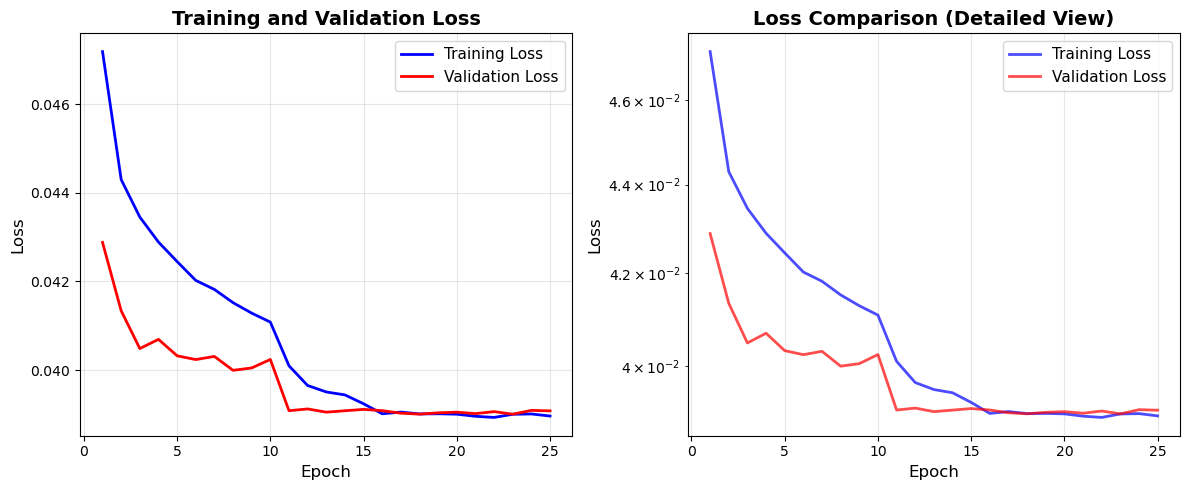


===== TRAINING SUMMARY =====
Final Training Loss: 0.0390
Final Validation Loss: 0.0391
Best Validation AUC: 0.8529
Total Epochs Trained: 25
Training stopped due to early stopping.


In [27]:
# ---------------- PLOT TRAINING CURVES ---------------- #
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot validation AUC if available
if len(train_losses) > 0:
    plt.subplot(1, 2, 2)
    # We can't plot AUC here directly since we didn't store it, but we can show the loss comparison
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
    plt.title('Loss Comparison (Detailed View)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss summary
print("\n===== TRAINING SUMMARY =====")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Total Epochs Trained: {len(train_losses)}")
if patience_counter >= CONFIG["patience"]:
    print("Training stopped due to early stopping.")

In [28]:
# ---------------- TEST ---------------- #
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate(model, testloader, criterion, CONFIG["device"])

C:\Users\Yasiru Laksara\AppData\Local\Temp\ipykernel_18388\4169206592.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_checkpoint_pa

[Test] Atelectasis AUC: 0.8138 | F1: 0.3972
[Test] Cardiomegaly AUC: 0.9364 | F1: 0.4912
[Test] Consolidation AUC: 0.7774 | F1: 0.2374
[Test] Edema AUC: 0.8950 | F1: 0.2706
[Test] Effusion AUC: 0.8991 | F1: 0.6050
[Test] Emphysema AUC: 0.9606 | F1: 0.5325
[Test] Fibrosis AUC: 0.8379 | F1: 0.1491
[Test] Hernia AUC: 0.9973 | F1: 0.7500
[Test] Infiltration AUC: 0.7058 | F1: 0.4007
[Test] Mass AUC: 0.9077 | F1: 0.4833
[Test] Nodule AUC: 0.7648 | F1: 0.3276
[Test] Pleural_Thickening AUC: 0.7932 | F1: 0.2411
[Test] Pneumonia AUC: 0.7054 | F1: 0.0621
[Test] Pneumothorax AUC: 0.8781 | F1: 0.3539
[Test] Avg AUC: 0.8480, Avg F1: 0.3787


In [29]:
print("\n===== TEST RESULTS =====")

# Overall metrics
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")

# Per-class metrics
print("\n=== Per-Class Metrics ===")
print("{:<20} {:<10} {:<10} {:<10}".format("Class", "AUROC", "F1", "Threshold"))
print("-" * 55)
for cls in test_stats['auc_dict'].keys():
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(cls, auc, f1, thr))

# Optional: average threshold
avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))



===== TEST RESULTS =====
Loss      : 0.0419
Avg AUROC : 0.8480
Avg F1    : 0.3787

=== Per-Class Metrics ===
Class                AUROC      F1         Threshold 
-------------------------------------------------------
Atelectasis          0.8138     0.3972     0.3822    
Cardiomegaly         0.9364     0.4912     0.3991    
Consolidation        0.7774     0.2374     0.3048    
Edema                0.8950     0.2706     0.3552    
Effusion             0.8991     0.6050     0.4112    
Emphysema            0.9606     0.5325     0.3138    
Fibrosis             0.8379     0.1491     0.2836    
Hernia               0.9973     0.7500     0.4902    
Infiltration         0.7058     0.4007     0.3614    
Mass                 0.9077     0.4833     0.4356    
Nodule               0.7648     0.3276     0.4054    
Pleural_Thickening   0.7932     0.2411     0.3204    
Pneumonia            0.7054     0.0621     0.2181    
Pneumothorax         0.8781     0.3539     0.4121    

Average Optimal Thresho

Generating predictions: 100%|██████████| 288/288 [00:44<00:00,  6.48it/s]


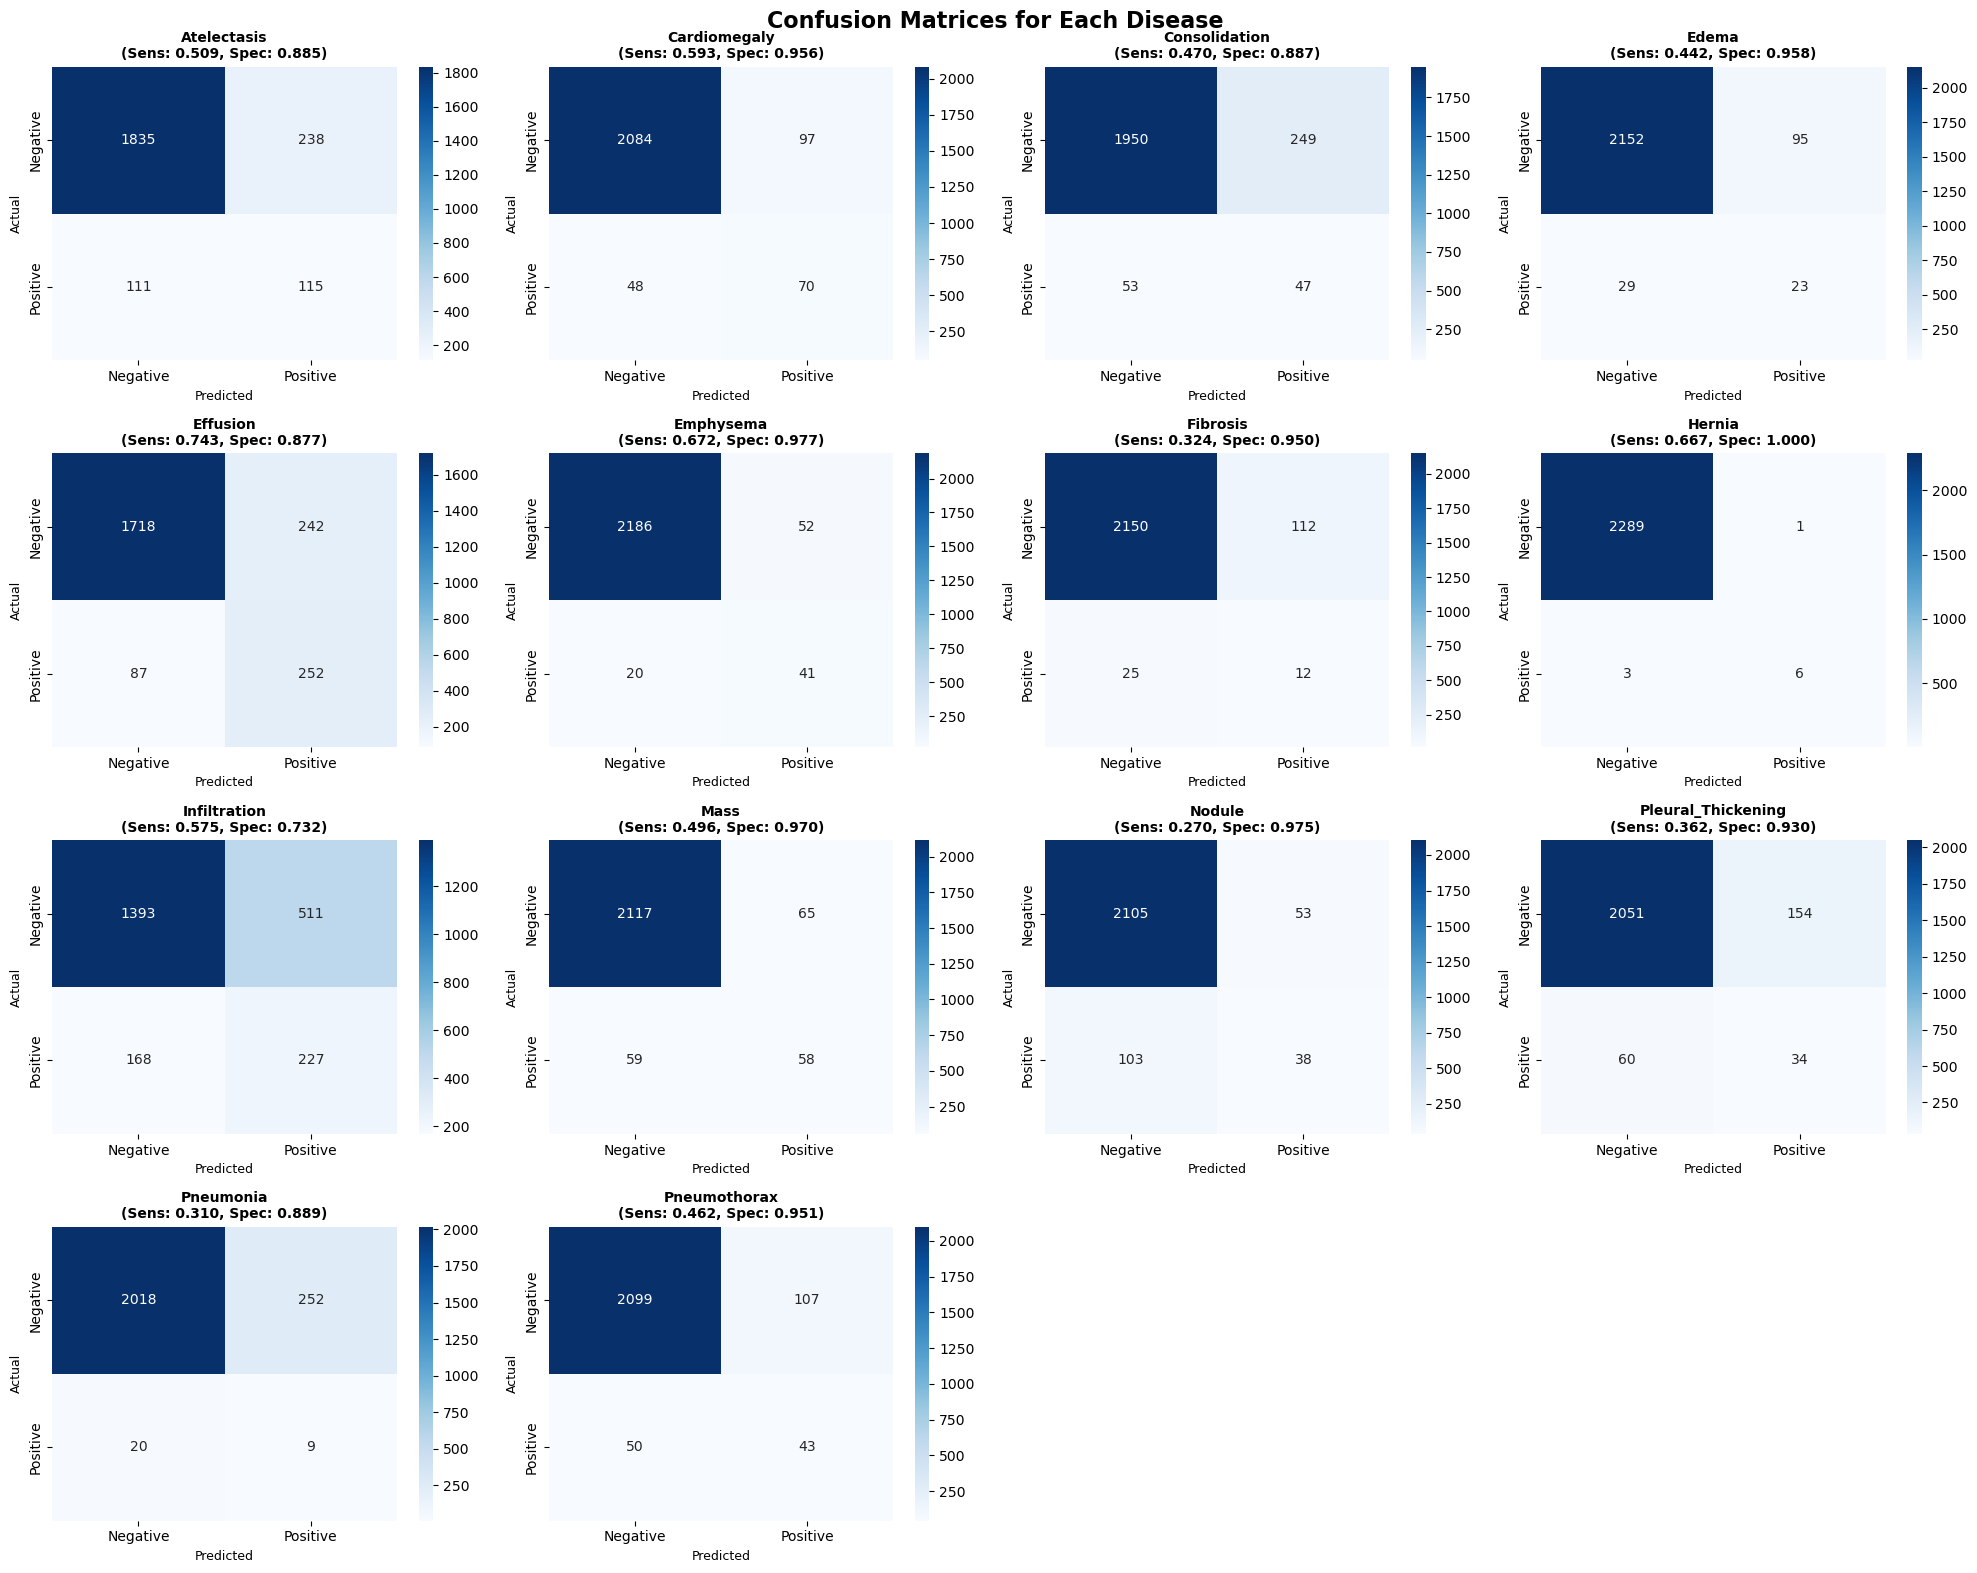

In [30]:
# ---------------- CONFUSION MATRIX ---------------- #
def generate_confusion_matrices(model, loader, device, thresholds):
    """
    Generate confusion matrices for multilabel classification.
    Since images can have multiple labels, we'll create individual confusion matrices for each disease.
    """
    model.eval()
    all_labels, all_preds = [], []
    
    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    # Convert predictions to binary using optimal thresholds
    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        threshold = thresholds[disease_list[i]]
        preds_binary[:, i] = (all_preds[:, i] > threshold).astype(int)
    
    # Create confusion matrices for each disease
    n_diseases = len(disease_list)
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Confusion Matrices for Each Disease', fontsize=16, fontweight='bold')
    
    # Store confusion matrix metrics
    cm_metrics = {}
    
    for i, disease in enumerate(disease_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Generate confusion matrix for this disease
        cm = confusion_matrix(all_labels[:, i], preds_binary[:, i])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        cm_metrics[disease] = {
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'NPV': npv
        }
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{disease}\n(Sens: {sensitivity:.3f}, Spec: {specificity:.3f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('Actual', fontsize=9)
    
    # Remove empty subplots (we have 14 diseases, so 2 empty spots)
    for i in range(n_diseases, 16):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    return cm_metrics

# Generate confusion matrices using test data and optimal thresholds
cm_metrics = generate_confusion_matrices(model, testloader, CONFIG["device"], test_stats['thresholds'])

In [31]:
# ---------------- DETAILED CONFUSION MATRIX METRICS ---------------- #
print("\n===== DETAILED CONFUSION MATRIX METRICS =====")
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8} {:<8} {:<8} {:<8}".format(
    "Disease", "TP", "TN", "FP", "FN", "Sens", "Spec", "Prec", "NPV"))
print("-" * 100)

for disease, metrics in cm_metrics.items():
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
        disease, 
        metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN'],
        metrics['Sensitivity'], metrics['Specificity'], 
        metrics['Precision'], metrics['NPV']
    ))

# Calculate and display average metrics
avg_sensitivity = np.mean([metrics['Sensitivity'] for metrics in cm_metrics.values()])
avg_specificity = np.mean([metrics['Specificity'] for metrics in cm_metrics.values()])
avg_precision = np.mean([metrics['Precision'] for metrics in cm_metrics.values()])
avg_npv = np.mean([metrics['NPV'] for metrics in cm_metrics.values()])

print("-" * 100)
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
    "AVERAGE", "-", "-", "-", "-", avg_sensitivity, avg_specificity, avg_precision, avg_npv))

print(f"\n===== SUMMARY =====")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average NPV: {avg_npv:.4f}")

# Additional multilabel-specific metrics
print(f"\n===== MULTILABEL CHARACTERISTICS =====")
total_samples = len(testloader.dataset)
# Count samples with multiple labels
samples_with_multiple_labels = 0
samples_with_no_findings = 0

# Count samples with multiple labels and no findings
for labels in testloader.dataset.dataframe['Finding Labels']:
    label_vector = get_label_vector(labels)
    if sum(label_vector) == 0:
        samples_with_no_findings += 1
    elif sum(label_vector) > 1:
        samples_with_multiple_labels += 1

print(f"Samples with multiple labels: {samples_with_multiple_labels}")
print(f"Samples with no findings: {samples_with_no_findings}")
print(f"Total test samples: {total_samples}")
print("Note: This is a multilabel classification problem where each image can have multiple diseases simultaneously.")


===== DETAILED CONFUSION MATRIX METRICS =====
Disease              TP     TN     FP     FN     Sens     Spec     Prec     NPV     
----------------------------------------------------------------------------------------------------
Atelectasis          115    1835   238    111    0.509    0.885    0.326    0.943   
Cardiomegaly         70     2084   97     48     0.593    0.956    0.419    0.977   
Consolidation        47     1950   249    53     0.470    0.887    0.159    0.974   
Edema                23     2152   95     29     0.442    0.958    0.195    0.987   
Effusion             252    1718   242    87     0.743    0.877    0.510    0.952   
Emphysema            41     2186   52     20     0.672    0.977    0.441    0.991   
Fibrosis             12     2150   112    25     0.324    0.950    0.097    0.989   
Hernia               6      2289   1      3      0.667    1.000    0.857    0.999   
Infiltration         227    1393   511    168    0.575    0.732    0.308    0.892   
Ma